Jonathon Nguyen

ID: 801093003

Homework 1

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
from torchvision import datasets
import time

In [2]:
def normalized_data(tensor):
    mean = torch.mean(tensor)
    std = torch.std(tensor)
    new_tensor = (tensor - mean) / std
    
    return new_tensor

def training_loop(epochs, optimizer, model, loss_fn, training_vars, validation_vars, 
                  training_prices, validation_prices):
    for epoch in range(1, epochs + 1):
        prices_p_train = model(training_vars)
        loss_train = loss_fn(prices_p_train, training_prices)
        
        prices_p_val = model(validation_vars)
        loss_val = loss_fn(prices_p_val, validation_prices)
        
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        
        print(f'Epoch {epoch}: Training Loss: {float(loss_train)}, Validation Loss: {float(loss_val)}')

In [9]:
NUM_EPOCHS = 200

# Read the data from the provided CSV files
housing = pd.DataFrame(pd.read_csv("Housing.csv"))

# Split the data into the input vars and the prices.
names_vars = ['area', 'bedrooms', 'bathrooms', 'stories', 'parking']
prices = housing['price']

# Find the length of the column.
num_samples = len(prices)
num_val = int(0.2 * num_samples)

# Generate the random indices with 80% training and 20% Validation
random_indices = torch.randperm(num_samples)
training_indices = random_indices[:-num_val]
validation_indices = random_indices[-num_val:]

# Turn input, prices and params into a tensor
training_vars = []
validation_vars = []
for col in names_vars: 
    # Convert the column into a tensor.
    tensor = torch.tensor(housing[col]).float()
    
    # Split the data set and normalized the data.
    training_tensor = normalized_data(tensor[training_indices])
    validation_tensor = normalized_data(tensor[validation_indices])
    
    # Packing the tensor into a list to pass as a param
    training_vars.append(training_tensor)
    validation_vars.append(validation_tensor)
    
training_vars = torch.stack(training_vars[:]).permute(1, 0)
validation_vars = torch.stack(validation_vars[:]).permute(1, 0)


# Convert the prices to a tensor.
prices = torch.tensor(prices.values).float()
price_training = prices[training_indices]
price_validation = prices[validation_indices]

housing[names_vars]

,area,bedrooms,bathrooms,stories,parking
0,7420,4,2,3,2
1,8960,4,4,4,3
2,9960,3,2,2,2
3,7500,4,2,2,3
4,7420,4,1,2,2
...,...,...,...,...,...
540,3000,2,1,1,2
541,2400,3,1,1,0
542,3620,2,1,1,0
543,2910,3,1,1,0


In [4]:
model = nn.Sequential(
        nn.Linear(5, 8),
        nn.Tanh(),
        nn.Linear(8, 1))

optimizer = optim.SGD(model.parameters(), lr=0.001)

In [5]:
training_loop(NUM_EPOCHS, optimizer, model, nn.MSELoss(), training_vars, validation_vars, price_training, price_validation)

P:\Anaconda3\envs\Python38\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([436])) that is different to the input size (torch.Size([436, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
P:\Anaconda3\envs\Python38\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([109])) that is different to the input size (torch.Size([109, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1: Training Loss: 25728521338880.0, Validation Loss: 28155110752256.0
Epoch 2: Training Loss: 25628711583744.0, Validation Loss: 28051251396608.0
Epoch 3: Training Loss: 24917137424384.0, Validation Loss: 27306705813504.0
Epoch 4: Training Loss: 24245318975488.0, Validation Loss: 26600227733504.0
Epoch 5: Training Loss: 23594541252608.0, Validation Loss: 25915467759616.0
Epoch 6: Training Loss: 22964185595904.0, Validation Loss: 25251714957312.0
Epoch 7: Training Loss: 22353583013888.0, Validation Loss: 24608342278144.0
Epoch 8: Training Loss: 21762123235328.0, Validation Loss: 23984699604992.0
Epoch 9: Training Loss: 21189195988992.0, Validation Loss: 23380182958080.0
Epoch 10: Training Loss: 20634251821056.0, Validation Loss: 22794219814912.0
Epoch 11: Training Loss: 20096667877376.0, Validation Loss: 22226204098560.0
Epoch 12: Training Loss: 19575968104448.0, Validation Loss: 21675580063744.0
Epoch 13: Training Loss: 19071592562688.0, Validation Loss: 21141844393984.0
Epoch 14

Epoch 170: Training Loss: 3585821638656.0, Validation Loss: 4092693839872.0
Epoch 171: Training Loss: 3582485069824.0, Validation Loss: 4087330635776.0
Epoch 172: Training Loss: 3579251785728.0, Validation Loss: 4082104270848.0
Epoch 173: Training Loss: 3576114708480.0, Validation Loss: 4077005570048.0
Epoch 174: Training Loss: 3573077245952.0, Validation Loss: 4072041349120.0
Epoch 175: Training Loss: 3570131533824.0, Validation Loss: 4067199549440.0
Epoch 176: Training Loss: 3567280717824.0, Validation Loss: 4062479384576.0
Epoch 177: Training Loss: 3564516671488.0, Validation Loss: 4057879281664.0
Epoch 178: Training Loss: 3561837559808.0, Validation Loss: 4053391376384.0
Epoch 179: Training Loss: 3559239450624.0, Validation Loss: 4049018814464.0
Epoch 180: Training Loss: 3556720508928.0, Validation Loss: 4044753469440.0
Epoch 181: Training Loss: 3554282307584.0, Validation Loss: 4040591409152.0
Epoch 182: Training Loss: 3551919079424.0, Validation Loss: 4036532895744.0
Epoch 183: T

Problem 2

In [30]:
from torchvision import transforms

transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4915, 0.4823, 0.4468),
                         (0.2470, 0.2435, 0.2616))
])

def training_loop(epochs, optimizer, model, loss_fn, train_loader, val_loader):
    training_losses = []
    val_losses = []
    accuracies = []
    for epoch in range(1, epochs + 1):
        
        correct_labels = 0
        count = 0
        with torch.no_grad():
            for imgs, labels in val_loader:
                output = model(imgs.view(imgs.shape[0], -1))
                loss_val = loss_fn(output, labels)
                _, predicted = torch.max(output, dim=1)
                count += labels.shape[0]
                correct_labels += int((predicted == labels).sum())
                
            val_losses.append(float(loss_val))
            accuracies.append(correct_labels/count)
        
        for imgs, labels in train_loader:
            output = model(imgs.view(imgs.shape[0], -1))
            loss = loss_fn(output, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        training_losses.append(float(loss))  
        print(f"Epoch: {epoch}, Training Loss: {loss}, Validation Loss: {loss_val}, Accuracy: {(correct_labels/count)*100}%")
        
    return training_losses, val_losses, accuracies

In [31]:
data = '.\cifar10'
cirfar10_train = datasets.CIFAR10(data, train=True, download=True, transform=transforms)
cirfar10_val = datasets.CIFAR10(data, train=False, download=True, transform=transforms)

class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

Files already downloaded and verified
Files already downloaded and verified


In [32]:
NUM_EPOCHS = 1
LEARNING_RATE = 1e-2
BATCH_SIZE = 512

model = nn.Sequential(
        nn.Linear(3072, 512),
        nn.Tanh(),
        nn.Linear(512, 10),
        nn.LogSoftmax(dim=1))

loss = nn.NLLLoss()

optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)
train_loader = torch.utils.data.DataLoader(cirfar10_train, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(cirfar10_val, batch_size=BATCH_SIZE, shuffle=False)

In [33]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

for imgs, labels in train_loader:
    imgs = imgs.to(device=device)
    labels = labels.to(device=device)
    
for imgs, labels in val_loader:
    imgs = imgs.to(device=device)
    labels = labels.to(device=device)
    
model = model.to(device=device)
print(f"Training on {device}")

Training on cpu


In [34]:
start_time = time.time()
training_losses, val_losses, accuracies = training_loop(NUM_EPOCHS, optimizer, model, loss, train_loader, val_loader)
end_time = time.time()

print(" ")
print(f"Final Loss: {training_losses[-1]}, Final Accuracy: {accuracies[-1]}, Training Time: {(end_time - start_time):.2f} seconds")

Epoch: 1, Training Loss: 1.8869653940200806, Validation Loss: 2.3102574348449707, Accuracy: 10.56%
 
Final Loss: 1.8869653940200806, Final Accuracy: 0.1056, Training Time: 33.63 seconds


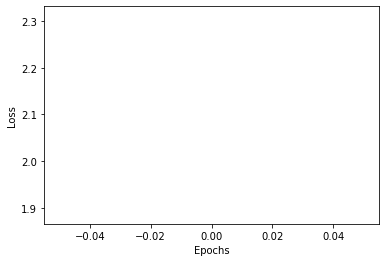

In [35]:
fig = plt.figure()
# Name the x and y axis
plt.xlabel("Epochs")
plt.ylabel("Loss")

# Plot the model and the actual values.
plt.plot(training_losses)
plt.plot(val_losses)

In [ ]:
model_new = nn.Sequential(
            nn.Linear(3072, 512),
            nn.Tanh(),
            nn.Linear(512, 1024),
            nn.Tanh(),
            nn.Linear(1024, 130),
            nn.Tanh(),
            nn.Linear(130, 10),
            nn.LogSoftmax(dim=1))

start_time = time.time()
model_loss = training_loop(NUM_EPOCHS, optimizer, model_new, loss, train_loader, val_loader)
end_time = time.time()

accuracy = model_accuracy(model, val_loader)
print(f"Final Loss: {model_loss}, Accuracy: {accuracy}, Training Time: {end_time - start_time} seconds")